Импортирование всех библиотек

In [1]:
import pandas as pd

from pymorphy3 import MorphAnalyzer

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import NearMiss

import re
import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import NearMiss
from sklearn.neighbors import KNeighborsClassifier

In [2]:
warnings.filterwarnings("ignore")

загрузка ранее сформированного датасета

In [3]:
data = pd.read_csv("restorans_16k.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16000 non-null  int64  
 1   оценка       15987 non-null  float64
 2   отзыв        15967 non-null  object 
 3   достоинства  2959 non-null   object 
 4   недостатки   2626 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 625.1+ KB


Нормальзация данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16000 non-null  int64  
 1   оценка       15987 non-null  float64
 2   отзыв        15967 non-null  object 
 3   достоинства  2959 non-null   object 
 4   недостатки   2626 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 625.1+ KB


In [5]:
data = data.drop(columns='Unnamed: 0')
data = data.drop(columns='достоинства')
data = data.drop(columns='недостатки')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   оценка  15987 non-null  float64
 1   отзыв   15967 non-null  object 
dtypes: float64(1), object(1)
memory usage: 250.1+ KB


In [6]:
data = data.dropna(subset=["оценка"])
data = data.dropna(subset=["отзыв"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15954 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   оценка  15954 non-null  float64
 1   отзыв   15954 non-null  object 
dtypes: float64(1), object(1)
memory usage: 373.9+ KB


ячейки выше удаляют не нужные столбцы(я удалил стобец с неправильными индексами и столбцы "достоинства" и "недостатки" так как данных в них слишком мало и при нормализации датасет может оказаться слишком маленьким), а так же нулевые значени в оставшихся строках

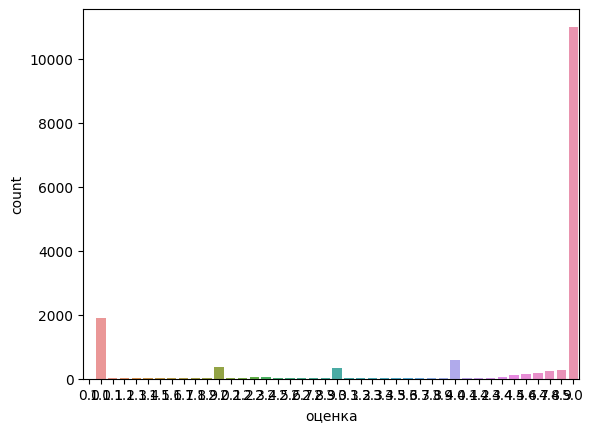

In [7]:
sns.countplot(x='оценка', data=data);

мы можем заметить что оценка идет по 0.1, это может стать проблемой, т.к. это будет мешать дальнейшему правильному обучению можели, а так же значений в 0.1 и в 5.0 слишком много

In [8]:
data = data[data.оценка < 5]
data = data[data.оценка > 0.2]

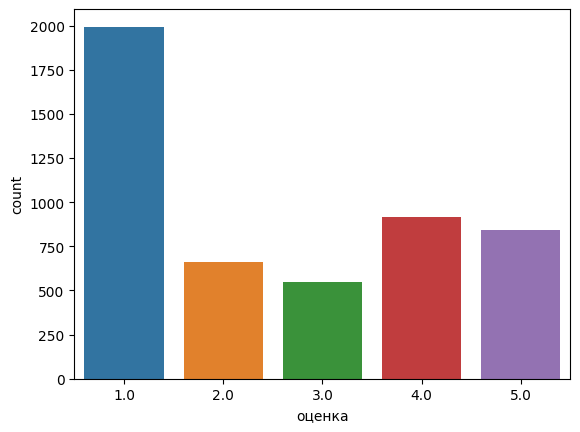

In [9]:
data = data.round()
data = data[data.оценка != 0]
sns.countplot(x='оценка', data=data);

In [10]:
data.оценка.value_counts()

оценка
1.0    1994
4.0     917
5.0     840
2.0     660
3.0     547
Name: count, dtype: int64

In [11]:
data = data.reset_index()
data = data.drop(columns = "index")

теперь оценки идут с разницей в единицу, так же после нормализации требуется обновить индексы

Далее я делаю лемматизацию предложений для отображения облака частовстречающихся слов и более точного обучения.

In [12]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer(lang='ru')
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens

In [13]:
data['_отзыв_'] = data.отзыв.apply(lambda x: lemmatize(x))
data.head()

оценка                                              отзыв  \
0     5.0  Хочу поблагодарить всю команду зала Добролюбоф...   
1     1.0  Отвратительное обслуживание Шоколадница на Лен...   
2     3.0  Почитав отзывы выбрал для ужина с семьей... в ...   
3     3.0  Вкусно, но очень скудные порции, просто очень....   
4     4.0  Персонал мега френдли начиная от портье и хост...   

                                             _отзыв_  
0  [хотеть, поблагодарить, команда, зал, добролюб...  
1  [отвратительный, обслуживание, шоколадница, ле...  
2  [почитать, отзыв, выбрать, ужин, семья, целое,...  
3  [вкусно, очень, скудный, порция, просто, очень...  
4  [персонал, мег, френдлить, начинать, портье, х...

ниже я загружаю все слова в один список и создаю облако частовстречащихся слов

In [14]:
tmp = data._отзыв_
all_words = []
for i in tmp:
    for j in i:
        all_words.append(j)

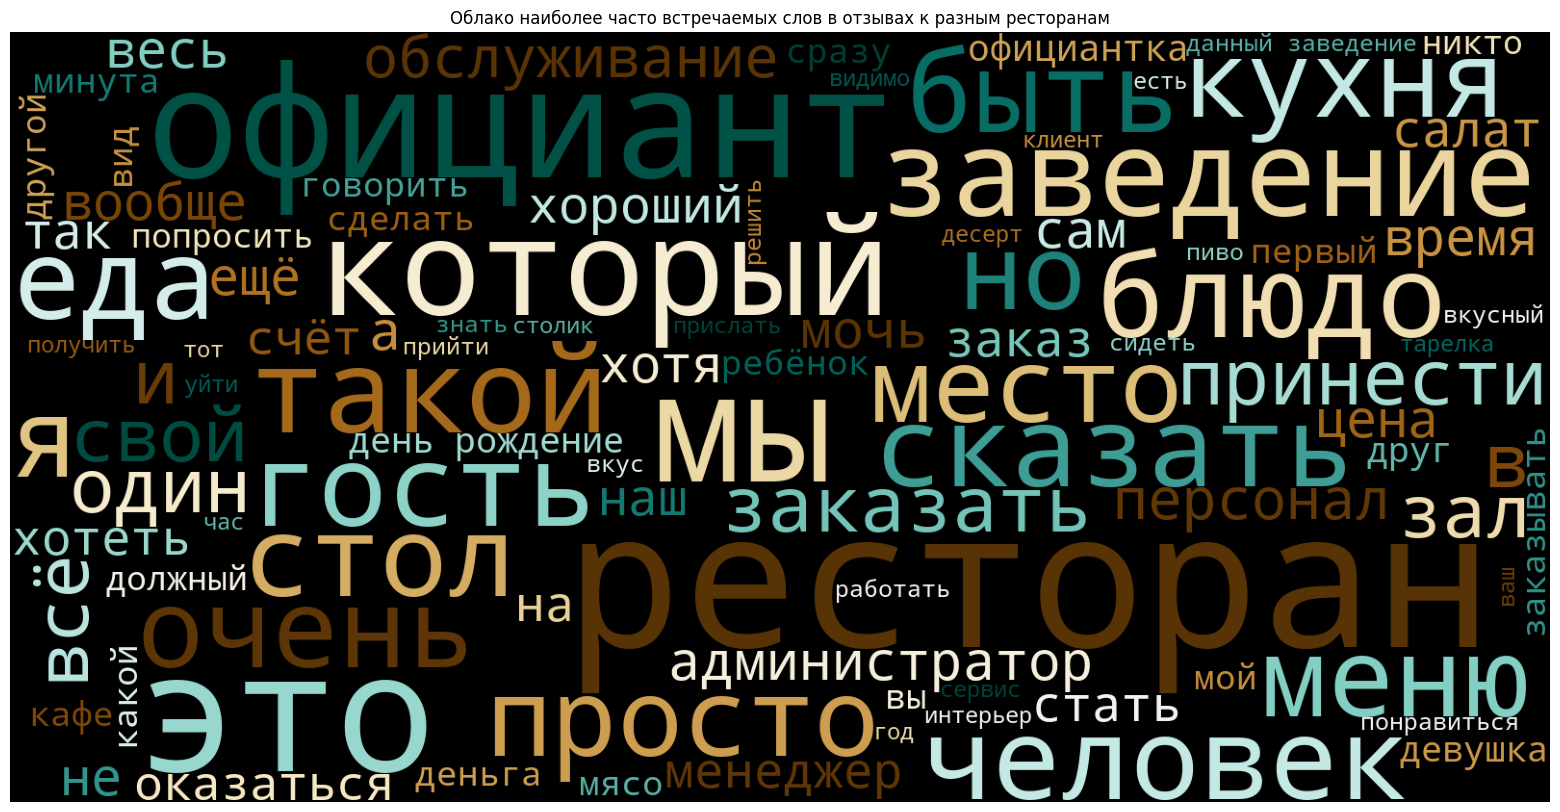

In [15]:
text_wordcloud= ' '.join(map(str, all_words)) 
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap='BrBG',background_color="black", collocations=True).generate(text_wordcloud)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Облако наиболее часто встречаемых слов в отзывах к разным ресторанам')
plt.axis("off")
plt.show()

In [16]:
tmp1 = data._отзыв_
for i in range(len(tmp1)):
    st = ""
    for j in tmp1[i]:
        st += j.replace(' ', '') + " "
    tmp1[i] = st
data.отзыв = tmp1
data = data.drop(columns = "_отзыв_")
data.head()

оценка                                              отзыв
0     5.0  хотеть поблагодарить команда зал добролюбофф п...
1     1.0  отвратительный обслуживание шоколадница ленинг...
2     3.0  почитать отзыв выбрать ужин семья целое позизи...
3     3.0  вкусно очень скудный порция просто очень обслу...
4     4.0  персонал мег френдлить начинать портье хостёс ...

в данной ячейке я превратил лемматизованные массивы слов в строки, по ранее проведенным результатам, это положительно влияет на обучение

In [17]:
y = data.оценка
X = data.отзыв

reviews = X

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(reviews)

In [18]:
nm = NearMiss()
X, y = nm.fit_resample(X, y)

в ячейках выше я отделяю целевую переменную и признак и векторизую признак, а так же балансирую классы с помощью библиотеки imblearn методом удаления лишних данных

в ячейке ниже я разделяю выборку на обучающую и тестовую с соотношением 8/2, провожу обучение моделей и вывод времени обучения, так же вывожу матрицу ошибок и точность оценки

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

start = time.time()
model1 = RandomForestClassifier(n_estimators=1000, random_state=0) 
model1.fit(X_train, y_train)
stop = time.time()
print("модель 1(случайный лес) обучена, время обучения :", (-start+stop) / 60, "минут")
start = time.time()
model2 = LogisticRegression()
model2.fit(X_train, y_train)
stop = time.time()
print("модель 2(логистическая регрессия) обучена, время обучения :", (-start+stop) / 60, "минут")
start = time.time()
model3 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200, random_state=0)
model3.fit(X_train, y_train)
stop = time.time()
print("модель 3(парцептрон) обучена, время обучения :", (-start+stop) / 60, "минут")
start = time.time()
model4 = KNeighborsClassifier(n_neighbors= 100)
model4.fit(X_train, y_train)
stop = time.time()
print("модель 4(соседи) обучена, время обучения :", (-start+stop) / 60, "минут")
models = [[model1, "лес"], [model2, "регрессия"], [model3, "парцептрон"], [model4, "соседи"]]

def check(model, name, X_train, X_test, y_train, y_test):
    
    
    y_pred = model.predict(X_test)

    print(name)
    print("Матрица ошибок:")
    print(confusion_matrix(y_test,y_pred))
#     print("Матрица класификационных ошибок:")
#     print(classification_report(y_test,y_pred))
    print("Доля правильно предсказанных текстов:")
    print(accuracy_score(y_test, y_pred))

for i in models:
    check(i[0], i[1], X_train, X_test, y_train, y_test)

модель 1(случайный лес) обучена, время обучения : 3.5288005153338116 минут
модель 2(логистическая регрессия) обучена, время обучения : 0.023100908597310385 минут
модель 3(парцептрон) обучена, время обучения : 3.430885461966197 минут
модель 4(соседи) обучена, время обучения : 0.0 минут
лес
Матрица ошибок:
[[93  5  7 12  4]
 [30 42 21  3  3]
 [22 33 28 13  9]
 [16  1  2 58 30]
 [ 8  1  0 37 69]]
Доля правильно предсказанных текстов:
0.5301645338208409
регрессия
Матрица ошибок:
[[84 13  6 12  6]
 [19 45 29  3  3]
 [17 40 35  8  5]
 [ 9  4  7 51 36]
 [ 4  2  5 38 66]]
Доля правильно предсказанных текстов:
0.5137111517367459
парцептрон
Матрица ошибок:
[[64 18 16 11 12]
 [22 44 25  4  4]
 [19 24 34 20  8]
 [ 5  5 13 47 37]
 [ 2  1  7 38 67]]
Доля правильно предсказанных текстов:
0.4680073126142596
соседи
Матрица ошибок:
[[  7   0   0 114   0]
 [ 20   0   0  77   2]
 [ 19   1   0  80   5]
 [  1   0   0 106   0]
 [  1   0   0 114   0]]
Доля правильно предсказанных текстов:
0.20658135283363802


в последней ячейке я предлагаю ввод своего отзыва, после векторизую его используя старую матрицу векторизации и вывожу предполагаемую оценку каждой модели
### отзыв для проверки :
Были сегодня в этом заведении не в первый раз. Приехали с подругой покушать. Подошла официант, недовольным тоном спросила, что мы будем, мы сделали заказ.. Чай чёрной с лимоном , вареники с творогом, салат, карпаччо, спагетти, медовик. Принесли чай, попросили подождать, чтобы он заварился. За разговором с подругой прошло минут 7-10, наливаем чай, чай напоминает по цвету зелёный. Попросили официанта переделать. Принес чай, попросил подождать, пока заварится. Подождали ещё минут 5. Не заварился. Совсем. Обернулась на кухню (кухня в заведении открытая), стоят 3 упаковки сметаны "простаквашино", прям в пачках, с со столовой ложкой внутри.. Позвали официанта, сказали, что чай не заваривается и необходимо его, отменить вареники и десерт мне, по причине того, что я не хочу есть сметану простоквашино с ложкой внутри, которой накладывали неизвестные мне другие блюда прошлым посетителям. Через 15 минут подошла девушка, представилась менеджером, без бейджика и без Имени, грубым тоном начала диалог , озвучив, что вареники уже готовятся поэтому их убирать из счёта они не будут. Диалог состоялся крайне неприятный и грубый и это в ресторане в центре Москвы со средним чеком в 3000! Хамство за гранью! В итоге я сказала, что платить за вареники не буду принципиально, потому что отменила их сразу и попросила удалиться и не разговаривать хамским тоном, так как являюсь клиентом. В итоге моей подруге принесли только салат и когда через 10 минут после того , как она она его съела , спросили, когда ожидать карпаччо и спагетти, нам было сказано, что мы все отменили и в ваш счёт будет включён только салат и чай. Такого хамства я не встречала нигде! Когда подходит менеджер, сначала он здоровается и представляется, а потом в мягком тоне начинает диалог, дабы не отвлекать гостей заведения, так как они пришли отдохнуть и поесть , а не вести диалог с хабалистой барышней непотребного вида. Спасибо за "чудесный" отдых в обеденный перерыв у Вас!
#### оценка по этому отзыву : 3

In [28]:
new_review = input("Введите свой отзыв: ")
new_review_vectorized = vectorizer.transform([new_review])
predicted_rating = model1.predict(new_review_vectorized)[0]
print(f"Предполагаемая оценка(лес): {predicted_rating}")
predicted_rating = model2.predict(new_review_vectorized)[0]
print(f"Предполагаемая оценка(регрессия): {predicted_rating}")
predicted_rating = model3.predict(new_review_vectorized)[0]
print(f"Предполагаемая оценка(парцептрон): {predicted_rating}")
predicted_rating = model4.predict(new_review_vectorized)[0]
print(f"Предполагаемая оценка(близжайшие соседи): {predicted_rating}")

Введите свой отзыв: Были сегодня в этом заведении не в первый раз. Приехали с подругой покушать. Подошла официант, недовольным тоном спросила, что мы будем, мы сделали заказ.. Чай чёрной с лимоном , вареники с творогом, салат, карпаччо, спагетти, медовик. Принесли чай, попросили подождать, чтобы он заварился. За разговором с подругой прошло минут 7-10, наливаем чай, чай напоминает по цвету зелёный. Попросили официанта переделать. Принес чай, попросил подождать, пока заварится. Подождали ещё минут 5. Не заварился. Совсем. Обернулась на кухню (кухня в заведении открытая), стоят 3 упаковки сметаны "простаквашино", прям в пачках, с со столовой ложкой внутри.. Позвали официанта, сказали, что чай не заваривается и необходимо его, отменить вареники и десерт мне, по причине того, что я не хочу есть сметану простоквашино с ложкой внутри, которой накладывали неизвестные мне другие блюда прошлым посетителям. Через 15 минут подошла девушка, представилась менеджером, без бейджика и без Имени, грубы

все модели близки к правильному ответу, но правильно ответили только первые две модели, случайный лес и логистическая регрессия